In [19]:
import datetime as dt
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, pandas as pd
warnings.filterwarnings("ignore", message="Could not infer format", category=UserWarning)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("Credit card transactions - India - Simple.csv")


In [14]:
print("Shape:", df.shape)

Shape: (26052, 7)


In [15]:
df.head(10)

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574
5,5,"Delhi, India",8-Sep-14,Silver,Bills,F,100036
6,6,"Delhi, India",24-Feb-15,Gold,Bills,F,143250
7,7,"Greater Mumbai, India",26-Jun-14,Platinum,Bills,F,150980
8,8,"Delhi, India",28-Mar-14,Silver,Bills,F,192247
9,9,"Delhi, India",1-Sep-14,Platinum,Bills,F,67932


Data wrangling

In [17]:
df.rename(columns={"Card Type":"Card_Type", "Exp Type":"Exp_Type"}, inplace=True) #renaming data

In [20]:
# Parse date column
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

In [21]:

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)

df.info()
## Create new time features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      26052 non-null  int64         
 1   City       26052 non-null  object        
 2   Date       26052 non-null  datetime64[ns]
 3   Card_Type  26052 non-null  object        
 4   Exp_Type   26052 non-null  object        
 5   Gender     26052 non-null  object        
 6   Amount     26052 non-null  int64         
 7   Year       26052 non-null  int32         
 8   Month      26052 non-null  int32         
 9   YearMonth  26052 non-null  object        
dtypes: datetime64[ns](1), int32(2), int64(2), object(5)
memory usage: 1.8+ MB


In [22]:
df

,index,City,Date,Card_Type,Exp_Type,Gender,Amount,Year,Month,YearMonth
0,0,"Delhi, India",2014-10-29,Gold,Bills,F,82475,2014,10,2014-10
1,1,"Greater Mumbai, India",2014-08-22,Platinum,Bills,F,32555,2014,8,2014-08
2,2,"Bengaluru, India",2014-08-27,Silver,Bills,F,101738,2014,8,2014-08
3,3,"Greater Mumbai, India",2014-04-12,Signature,Bills,F,123424,2014,4,2014-04
4,4,"Bengaluru, India",2015-05-05,Gold,Bills,F,171574,2015,5,2015-05
...,...,...,...,...,...,...,...,...,...,...
26047,26047,"Kolkata, India",2014-06-22,Silver,Travel,F,128191,2014,6,2014-06
26048,26048,"Pune, India",2014-08-03,Signature,Travel,M,246316,2014,8,2014-08
26049,26049,"Hyderabad, India",2015-01-16,Silver,Travel,M,265019,2015,1,2015-01
26050,26050,"Kanpur, India",2014-09-14,Silver,Travel,M,88174,2014,9,2014-09


3. Exploratory Data Analysis (EDA)

In [26]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode" 

In [27]:
top_cities = (
    df.groupby("City", as_index=False)["Amount"].sum()
      .sort_values("Amount", ascending=False)
      .head(10)
)
top_cities

px.bar(top_cities, x="City", y="Amount", title="Top 10 Cities by Spend")

In [28]:
monthly_spend = (
    df.groupby("YearMonth", as_index=False)["Amount"].sum()
      .sort_values("YearMonth"))
px.line(monthly_spend, x="YearMonth", y="Amount", title="Monthly Total Spend", markers=True)

In [30]:
exp_contrib = (
 df.groupby("Exp_Type", as_index=False)["Amount"].sum()
  .sort_values("Amount", ascending=False))
px.bar(exp_contrib, x="Exp_Type", y="Amount", title="Expense Type Contribution")

Observations
- Top 3 cities by spend are Greater Mumbai,Bengaluru,Ahmedabad.
- Monthly spend shows highest peaks in jan 2025.
- Bills, Food, and Fuel contribute the most to total spend.

Spending Habits by Gender

In [35]:
gender_stats = ( df.groupby("Gender")
 .agg(total_spend=("Amount","sum"),
avg_ticket=("Amount","mean"),
 txns=("Amount","size"))
.reset_index()
)
gender_stats

px.bar(gender_stats, x="Gender", y="total_spend", title="Total Spend by Gender")

Spend by Card Type

In [ ]:
card_overview = (
    df.groupby("Card_Type")
      .agg(total_spend=("Amount","sum"),
     txns=("Amount","size"),
     avg_ticket=("Amount","mean"))
      .reset_index()
      .sort_values("total_spend", ascending=False))
card_overview

px.bar(card_overview, x="Card_Type", y="total_spend",
       hover_data=["txns","avg_ticket"],
       title="Total Spend by Card Type")

Gender × Card Type habits

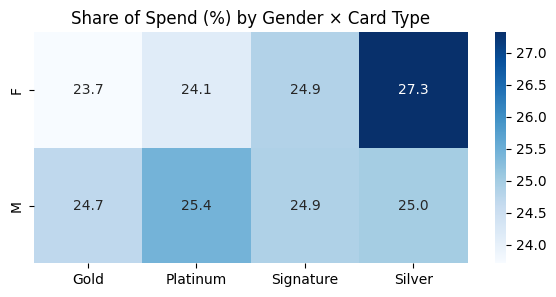

In [ ]:
gxc = (
    df.groupby(["Gender","Card_Type"])["Amount"]
      .sum()
      .reset_index()
      .sort_values(["Gender","Amount"], ascending=[True, False])
)

gxc["gender_total"] = gxc.groupby("Gender")["Amount"].transform("sum")
gxc["share_within_gender_pct"] = (gxc["Amount"] / gxc["gender_total"] * 100).round(2)
gxc

# Heatmap-style pivot
pivot = gxc.pivot(index="Gender", columns="Card_Type", values="share_within_gender_pct").fillna(0)
plt.figure(figsize=(7,3))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues")
plt.title("Share of Spend (%) by Gender × Card Type")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [ ]:
monthly = (
    df.groupby("YearMonth", as_index=False)["Amount"].sum()
      .sort_values("YearMonth")
     .rename(columns={"Amount":"total_spend"})
)

# MoM growth
monthly["prev"] = monthly["total_spend"].shift(1)
monthly["mom_growth"] = ( (monthly["total_spend"] - monthly["prev"]) / monthly["prev"] * 100 ).round(2)
monthly.head(10)

fig = px.line(monthly, x="YearMonth", y="total_spend", title="Monthly Total Spend", markers=True)
fig.show()

px.bar(monthly.tail(12), x="YearMonth", y="mom_growth",
     title="MoM Growth (%) — last 12 months").show()

Transaction Amount Distribution

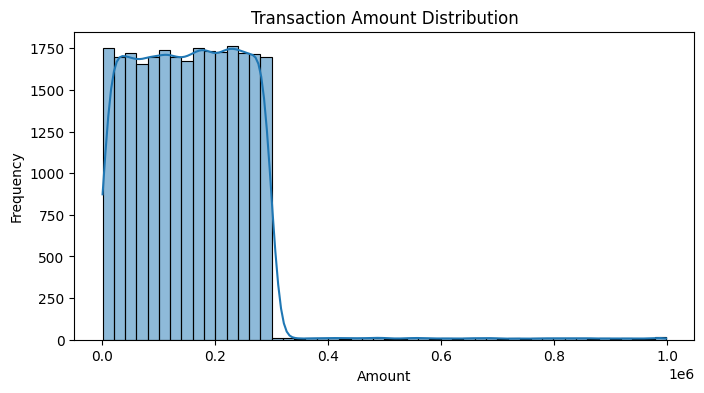

In [46]:
plt.figure(figsize=(8,4))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()



Expense Type vs Card Type

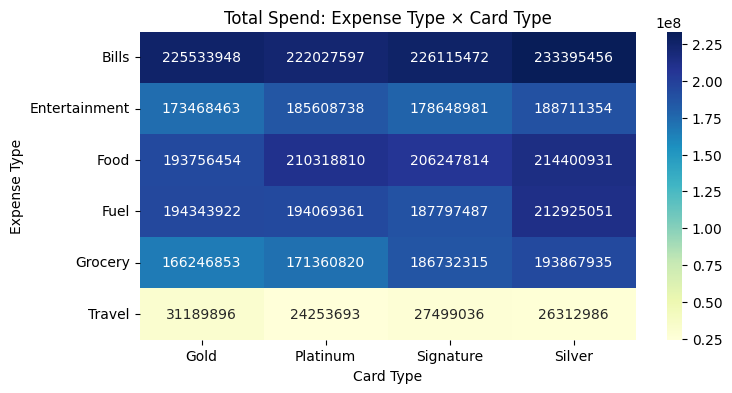

In [47]:
exp_card = df.groupby(["Exp_Type","Card_Type"])["Amount"].sum().reset_index()
pivot_exp_card = exp_card.pivot(index="Exp_Type", columns="Card_Type", values="Amount").fillna(0)

plt.figure(figsize=(8,4))
sns.heatmap(pivot_exp_card, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Total Spend: Expense Type × Card Type")
plt.ylabel("Expense Type")
plt.xlabel("Card Type")
plt.show()

# Final Insights 


Top spending cities (Top 5 & share of total = 58.63%)
  - Greater Mumbai — ₹576,751,476
  - Bengaluru — ₹572,326,739
  - Ahmedabad — ₹567,794,310
  - Delhi — ₹556,929,212
  - Kolkata — ₹115,466,943

- Peak months / seasonality
- January — ₹431,209,556
  - October — ₹419,846,007
  - December — ₹416,935,415

- Biggest expense categories
  - Bills — ₹907,072,473
  - Food — ₹824,724,009
  - Fuel — ₹789,135,821

- Gender patterns
  - Female (F): total ₹2,205,311,030| avg ticket ₹161,207 | txns 13,680
  - Male (M): total   ₹1,869,522,343 | avg ticket ~₹151,109 | txns 12,372
  - _Females lead on total spend, average ticket, and transaction count._

- Card-type patterns
  - Total spend (desc):Silver ₹1,069,613,713 → Signature ₹1,013,041,105 → Platinum ₹1,007,639,019 → Gold **₹984,539,536 (very close totals)
  -

## Key metrics

-Date range analyzed:2013-10-04 → 2015-05-26
- Total transactions:26,052
- Total spend:₹4,074,833,373
- Coverage:986 unique cities | 6 expense types | 4 card types

## Observations & takeaways

- Spend is concentrated in the metros — Top 5 cities alone contribute ~59% of total spend.
- Festive/winter months (Oct–Dec) and January are the strongest periods; campaigns should lean into these peaks.
- Bills, Food, and Fuel dominate category spend; tailor offers and partnerships here.
- Female customers show higher total and average spend**; personalization can unlock even more value.
- Premium tiers (Platinum/Signature) have the **highest average ticket**, even if totals are similar across tiers.